In [2]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob

#import geopandas as gpd
import pandas as pd

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

# from utils import *
# from utils import basics as bsc
# from utils import plotting as pt

import utils.basics as bsc 
import utils.plotting as pt

# import importlib
# importlib.reload(pt)


In [3]:
# PATHS
S2_stacked_1 = "../data/02_processed/S2_Stacked_Site_1.tif"
S2_stacked_2 = "../data/02_processed/S2_Stacked_Site_2.tif"
S2_stacked_1_normalized = "../data/02_processed/S2_Stacked_Site_1_norm.tif"
S2_stacked_2_normalized = "../data/02_processed/S2_Stacked_Site_2_norm.tif"
ALS_PATH1_RES = "../data/02_processed/ALS_resampled_site1.tif"
ALS_PATH2_RES = "../data/02_processed/ALS_resampled_site2.tif"
ALS_PATH1_P = '../data/02_processed/ALS_GT01_2024_processed.tif'
ALS_PATH2_P = '../data/02_processed/ALS_GT02_2024_processed.tif'

FOREST_MASK1 = '../data/02_processed/fmask_01_Ebrach.tif' #ebrach
FOREST_MASK2 = '../data/02_processed/fmask_02_Waldbrunn.tif' #waldbrunn

## load rasters

In [4]:
# Load S2 and merged ALS data for both sites and combine them in an array
s2_np, als_np, band_names = bsc.load_rasters(S2_stacked_1_normalized, ALS_PATH1_RES)
s2_np2, als_np2, band_names = bsc.load_rasters(S2_stacked_2_normalized, ALS_PATH2_RES)
fmask1 = bsc.read_tif_as_array(FOREST_MASK1)
fmask2 = bsc.read_tif_as_array(FOREST_MASK2)

✅ Loaded S2: (13, 846, 1241), ALS: (846, 1241)
S2_Stacked_Site_1_norm.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre
  Band names: ('BLU_Q50', 'BNR_Q50', 'EVI_Q50', 'GRN_Q50', 'NBR_Q50', 'NDV_Q50', 'NIR_Q50', 'RE1_Q50', 'RE2_Q50', 'RE3_Q50', 'RED_Q50', 'SW1_Q50', 'SW2_Q50')

ALS_resampled_site1.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

✅ Loaded S2: (13, 1002, 815), ALS: (1002, 815)
S2_Stacked_Site_2_norm.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 9.99 x 10.00 metre
  Band names: ('BLU_Q50', 'BNR_Q50', 'EVI_Q50', 'GRN_Q50', 'NBR_Q50', 'NDV_Q50', 'NIR_Q50', 'RE1_Q50', 'RE2_Q50', 'RE3_Q50', 'RED_Q50', 'SW1_Q50', 'SW2_Q50')

ALS_resampled_site2.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 9.99 x 10.00 metre

✅ Loaded fmask_01_Ebrach.tif: shape=(846, 1241), CRS=EPSG:25832, GSD=10.00 x 10.00 metre
Band names: (None,)
✅ Loaded fmask_02_Waldbrunn.tif: shape=(1002, 815), CRS=EPSG:25832, GSD=10.00 x 10.00 m

## plot the images

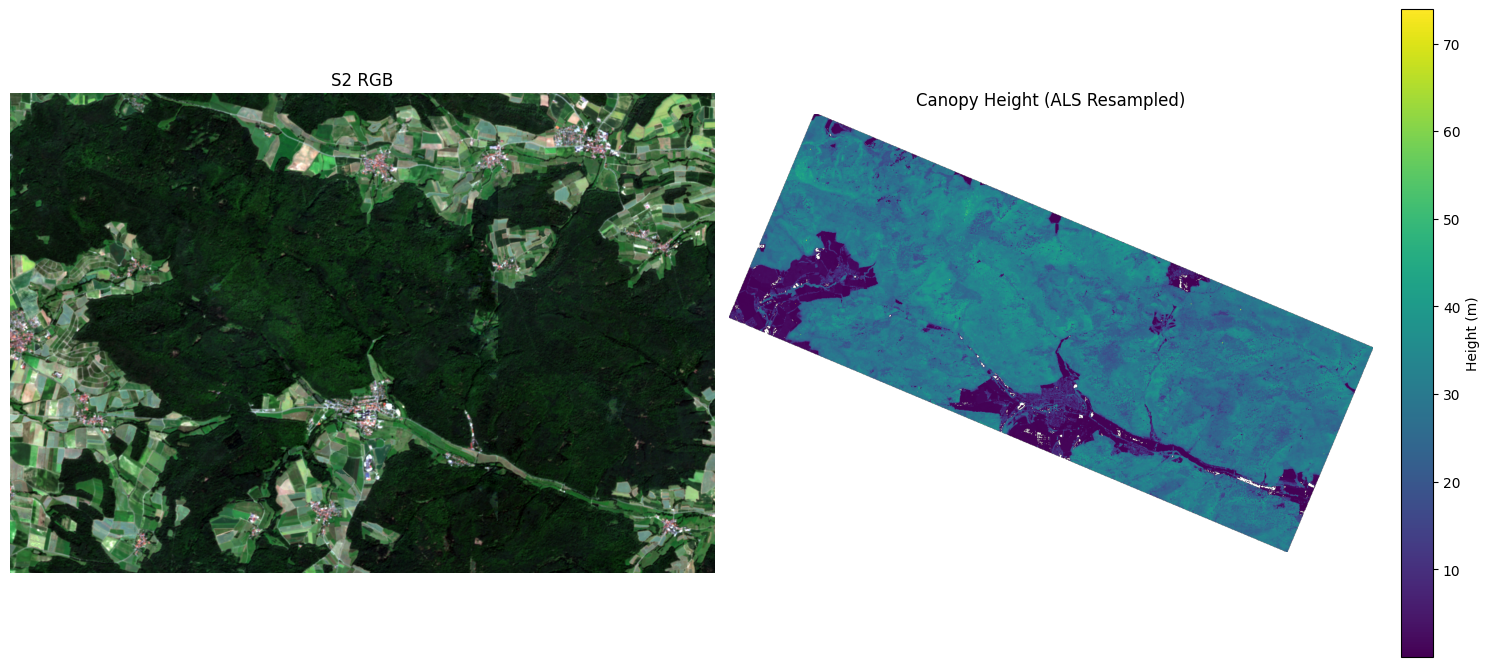

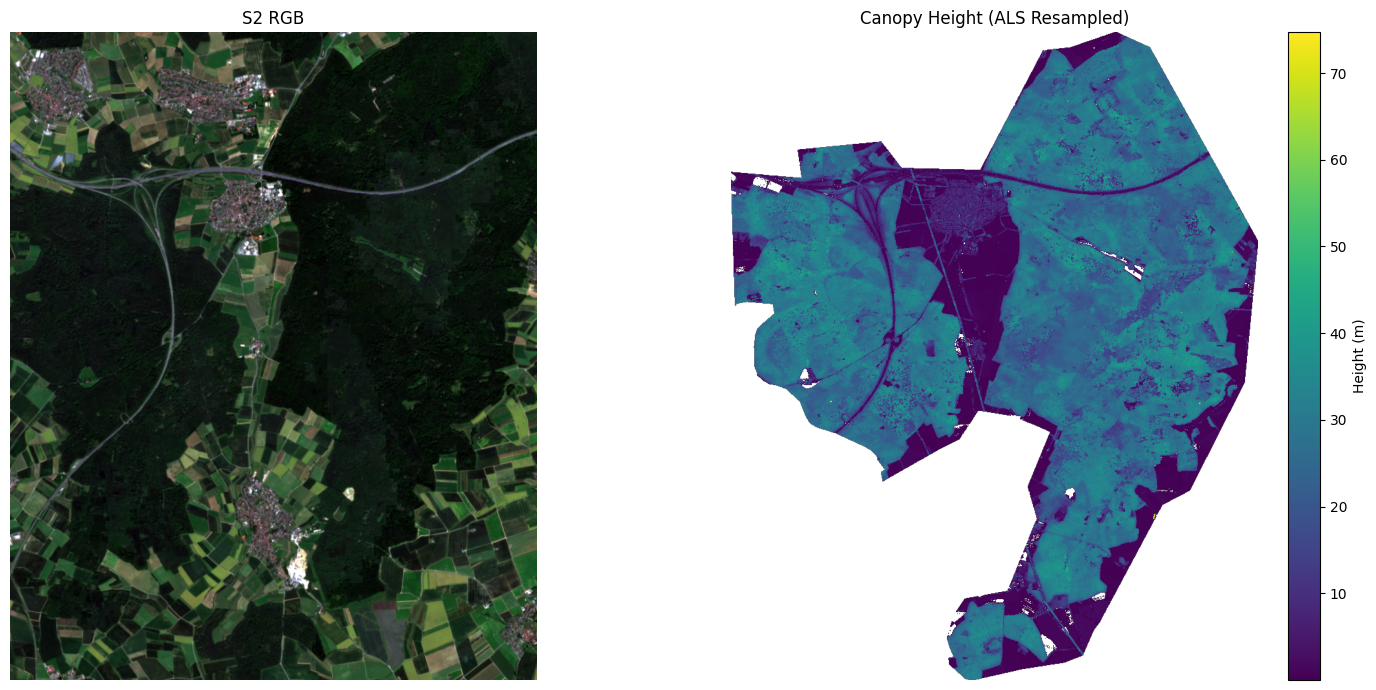

In [5]:
pt.plot_full_image(s2_np, als_np)
pt.plot_full_image(s2_np2, als_np2)

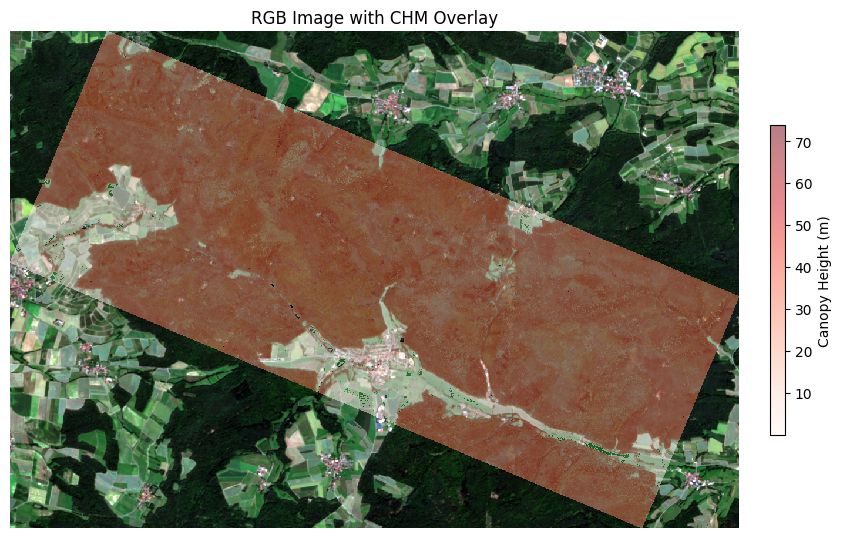

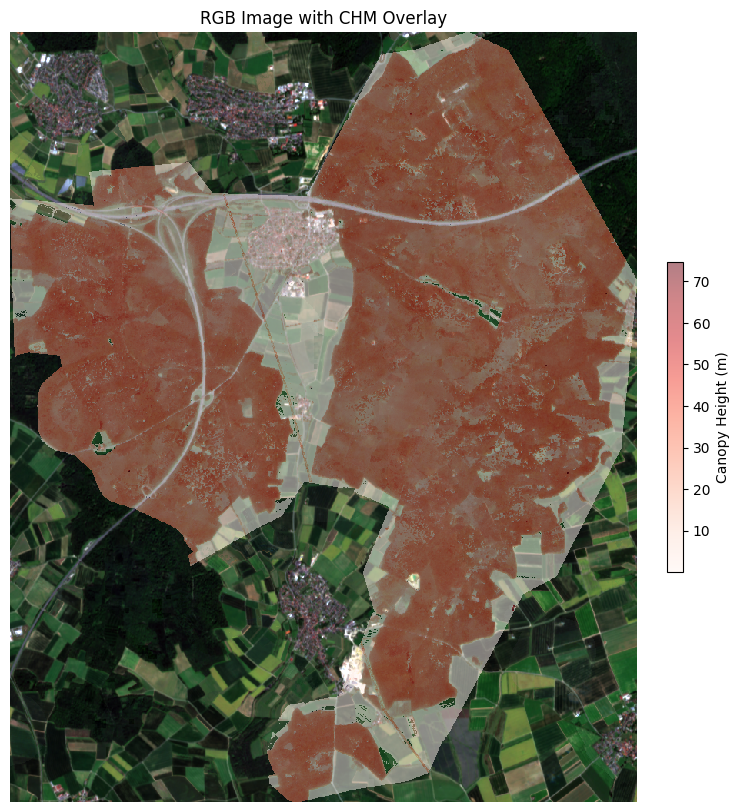

In [6]:
pt.plot_overlay(s2_np, als_np,norm_rgb=False) # already normalized
pt.plot_overlay(s2_np2, als_np2, norm_rgb=False) # already normalized


## get data stats

In [7]:
# Get file sizes in megabytes (MB)
als_file_size = os.path.getsize(ALS_PATH2_RES) / (1024 * 1024)  # Convert bytes to MB
s2_file_size = os.path.getsize(S2_stacked_2) / (1024 * 1024)  # Convert bytes to MB

print(f"ALS file size: {als_file_size:.2f} MB")
print(f"S2 stacked multiband file size: {s2_file_size:.2f} MB")

ALS file size: 3.12 MB
S2 stacked multiband file size: 20.26 MB


In [8]:
def calculate_coverage_and_area(als, s2, band_idx=3, pixel_size=10):
    """
    Calculate the coverage and overlap between ALS and a specific S2 band.

    Parameters:
    - als: numpy array of ALS data (height, width)
    - s2: numpy array of S2 data (bands, height, width)
    - band_idx: index of the S2 band to compare (default: 3 for green channel)
    - pixel_size: size of one pixel in meters (default: 10m x 10m)

    Returns:
    - valid_pixel_count: number of valid overlapping pixels
    - percentage: percentage of ALS pixels with valid S2 data
    - area: area in square meters of valid overlapping pixels
    """
    # Mask invalid ALS and S2 data
    als_valid = ~np.isnan(als) & (als >= 0)
    s2_valid = ~np.isnan(s2[band_idx]) & (s2[band_idx] >= 0)

    # Calculate overlap
    valid_overlap = als_valid & s2_valid
    valid_pixel_count = np.sum(valid_overlap)

    # Calculate percentage and area
    total_als_pixels = np.sum(als_valid)
    percentage = (valid_pixel_count / total_als_pixels) * 100 if total_als_pixels > 0 else 0
    als_area_full = np.sum(als_valid) * (pixel_size ** 2) / 1e6   # Area in square kilometers
    area_km2_avail = valid_pixel_count * (pixel_size ** 2) / 1e6  # Convert to square kilometers

    # Calculate percentage of vegetated area with data availability
    vegetated_area = np.sum((als > 2) & ~np.isnan(als))
    vegetated_overlap = np.sum((als > 2) & valid_overlap)
    vegetated_percentage = (vegetated_overlap / vegetated_area) * 100 if vegetated_area > 0 else 0

    print(f"ALS area (all valid CHM):             {als_area_full:10.2f} km²")
    print(f"Valid overlapping pixels:               {valid_pixel_count:10,d}")
    print(f"Area of valid overlapping pixels:     {area_km2_avail:10.2f} km²")
    print(f"ALS pixels with valid S2 data:        {percentage:10.2f} %")
    print(f"Vegetated area with data availability:{vegetated_percentage:10.2f} % (CHM > 2m)")

    return #valid_pixel_count, percentage, als_area_full, area_km2_avail, vegetated_percentage


In [9]:
calculate_coverage_and_area(als_np, s2_np, band_idx=3)

ALS area (all valid CHM):                  49.85 km²
Valid overlapping pixels:                  498,465
Area of valid overlapping pixels:          49.85 km²
ALS pixels with valid S2 data:            100.00 %
Vegetated area with data availability:    100.00 % (CHM > 2m)


In [10]:
calculate_coverage_and_area(als_np2, s2_np2, band_idx=3)

ALS area (all valid CHM):                  44.41 km²
Valid overlapping pixels:                  444,050
Area of valid overlapping pixels:          44.41 km²
ALS pixels with valid S2 data:            100.00 %
Vegetated area with data availability:    100.00 % (CHM > 2m)


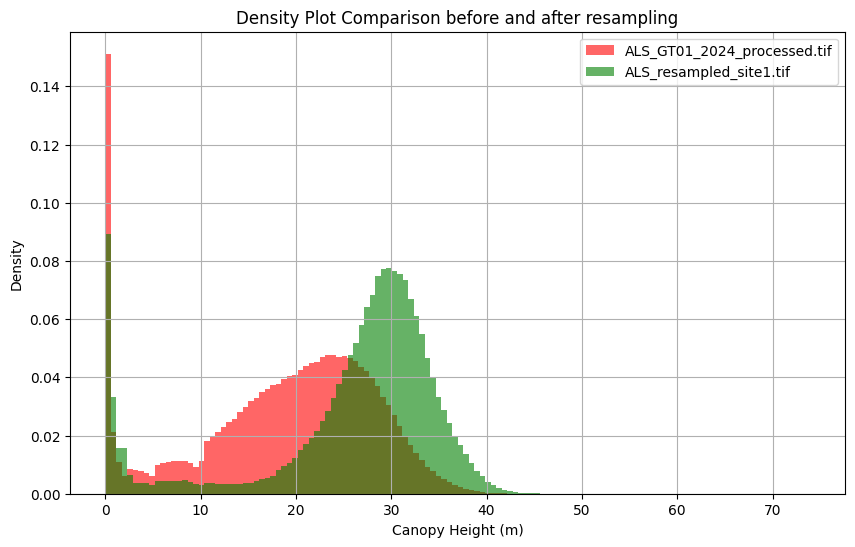


Percentiles Table:
            ALS_GT01_2024_processed.tif  ALS_resampled_site1.tif  delta
Percentile                                                             
0th                                0.00                     0.01   0.01
5th                                0.13                     0.56   0.43
10th                               1.18                     5.09   3.91
50th                              20.50                    28.55   8.05
75th                              25.91                    31.85   5.94
90th                              29.66                    34.66   5.00
95th                              31.70                    36.41   4.71
98th                              33.98                    38.25   4.27
99th                              35.46                    39.43   3.97
100th                             73.91                    73.91   0.00


In [45]:
pt.plot_two_density_and_percentiles(ALS_PATH1_P, ALS_PATH1_RES)

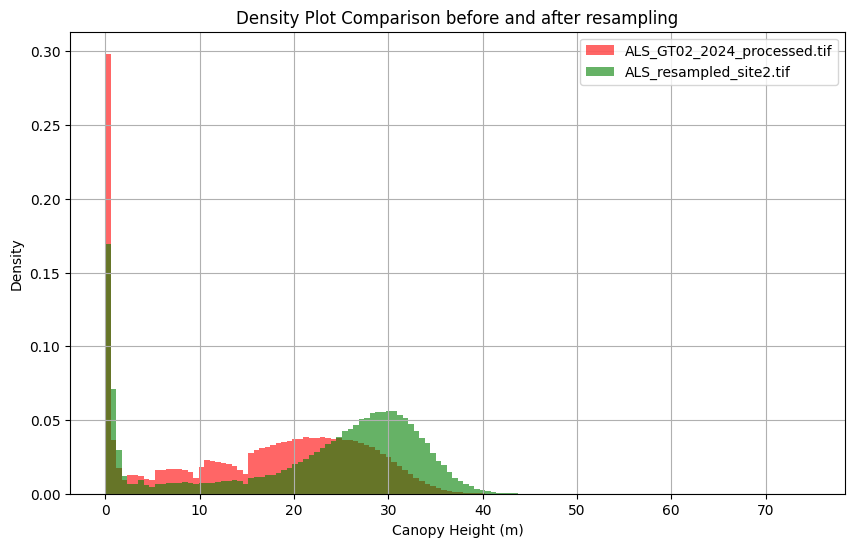


Percentiles Table:
            ALS_GT02_2024_processed.tif  ALS_resampled_site2.tif  delta
Percentile                                                             
0th                                0.00                     0.01   0.01
5th                                0.08                     0.39   0.31
10th                               0.20                     0.60   0.40
50th                              17.93                    25.78   7.85
75th                              24.69                    30.57   5.88
90th                              29.05                    33.67   4.62
95th                              31.11                    35.31   4.20
98th                              33.21                    37.14   3.93
99th                              34.55                    38.34   3.79
100th                             74.69                    74.69   0.00


In [46]:
pt.plot_two_density_and_percentiles(ALS_PATH2_P, ALS_PATH2_RES)

--> Cool, this distribution is somehow expected when doing a 98th percentile aggregation. We shift the distribution slightly to the right. 

## S2 Histograms

S2: Temporal composites: 
- basic approach: summer median composite (June - August) --> assumption, that underlying signal in S2 doenst change over this time; downside: coherence between pixels is lost.
- more sophisticated approach: stack temporal data; temporal dynamics are still inside

Indices to drop:
- EVI
- NBR 
- NDV 
--> drop them, cause they're indices, made up from the other bands. 
we drop them for better comparability to other approaches. 
-> Hypothesis: Model should learn better with Indices. 

How to normalize the remaining?
- raw BANDS: 0 to 1; clip to 0.1 and 99.9 percentile before.



B1_BLU  B2_BNR  B3_EVI  B4_GRN  B5_NBR  B6_NDV  B7_NIR  B8_RE1  \
P0           0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
P0.1         0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
P25          0.06    0.44    0.48    0.11    0.61    0.63    0.45    0.15   
P50          0.09    0.51    0.56    0.16    0.71    0.71    0.51    0.20   
P75          0.23    0.59    0.65    0.39    0.77    0.76    0.60    0.47   
P95          0.53    0.76    0.80    0.63    0.89    0.90    0.77    0.69   
P99.9        1.00    1.00    1.00    1.00    1.00    1.00    1.00    1.00   
P100         1.00    1.00    1.00    1.00    1.00    1.00    1.00    1.00   
NaN Ratio    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

           B9_RE2  B10_RE3  B11_RED  B12_SW1  B13_SW2  
P0           0.00     0.00     0.00     0.00     0.00  
P0.1         0.00     0.00     0.00     0.00     0.00  
P25          0.41     0.41     0.05     0.39     0.16  
P50          0.47     0.48     0.07     0.45     0.19  
P75          0.55     0.56     0.22     0.57     0.34  
P95          0.75     0.74     0.55     0.74     0.54  
P99.9        1.00     1.00     1.00     1.00     1.00  
P100         1.00     1.00     1.00     1.00     1.00  
NaN Ratio    0.00     0.00     0.00     0.00     0.00

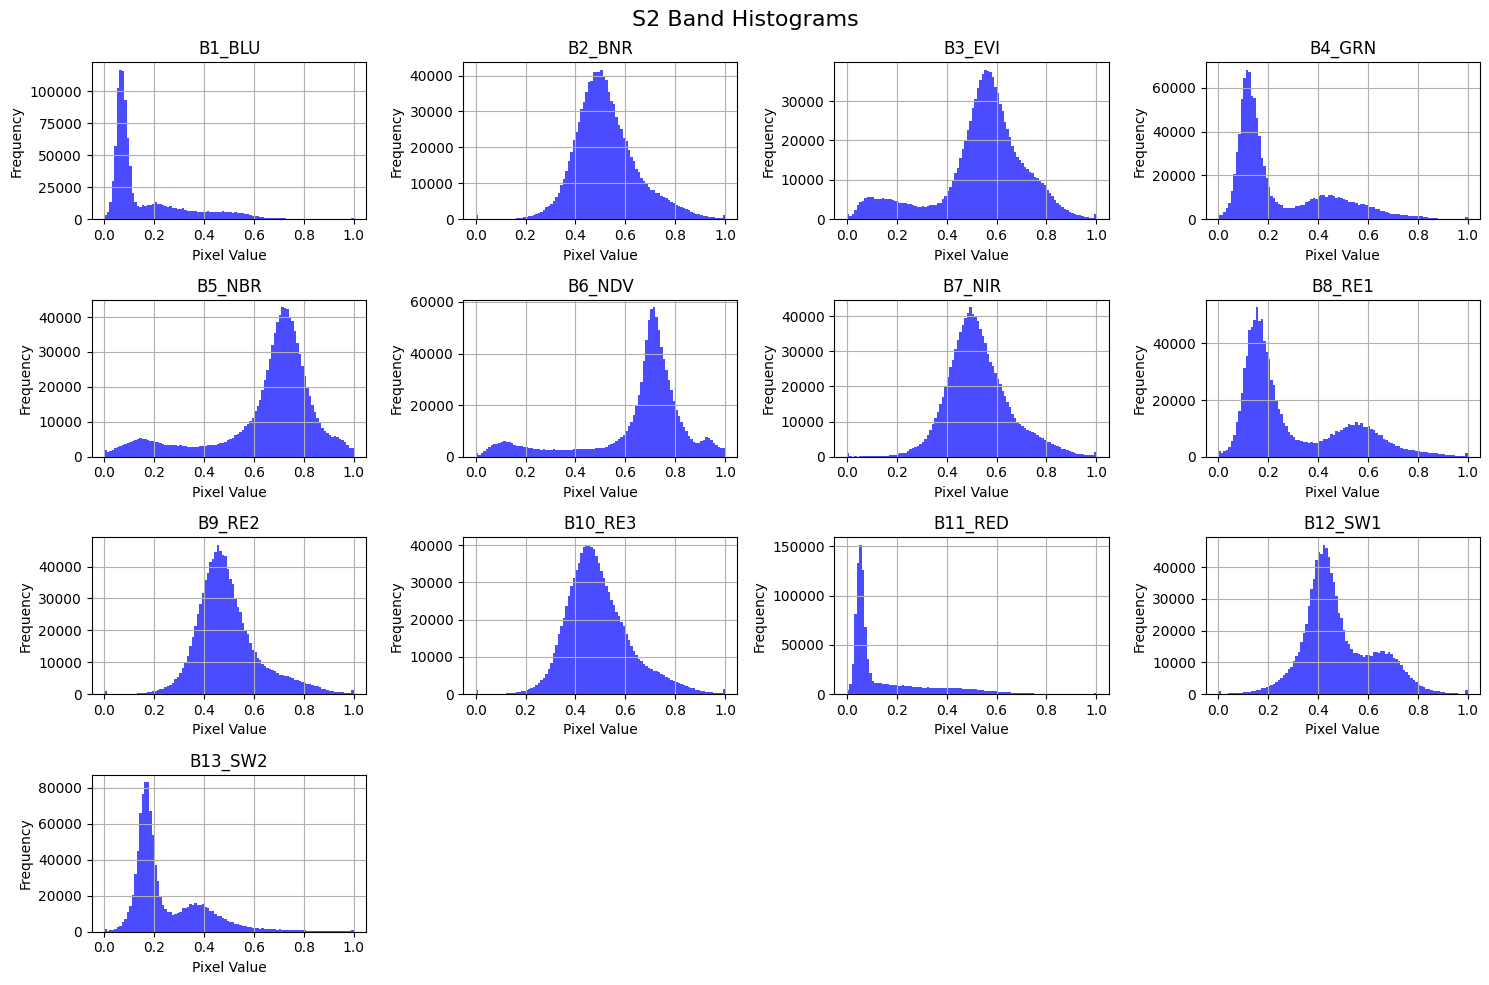

B1_BLU  B2_BNR  B3_EVI  B4_GRN  B5_NBR  B6_NDV  B7_NIR  B8_RE1  \
P0           0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
P0.1         0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
P25          0.05    0.37    0.23    0.08    0.28    0.33    0.38    0.09   
P50          0.09    0.45    0.60    0.12    0.77    0.86    0.47    0.15   
P75          0.17    0.53    0.70    0.27    0.89    0.93    0.54    0.35   
P95          0.32    0.65    0.79    0.44    0.94    0.96    0.66    0.56   
P99.9        1.00    1.00    1.00    1.00    1.00    1.00    1.00    1.00   
P100         1.00    1.00    1.00    1.00    1.00    1.00    1.00    1.00   
NaN Ratio    0.00    0.00    0.00    0.00    0.01    0.00    0.00    0.00   

           B9_RE2  B10_RE3  B11_RED  B12_SW1  B13_SW2  
P0           0.00     0.00     0.00     0.00     0.00  
P0.1         0.00     0.00     0.00     0.00     0.00  
P25          0.35     0.35     0.04     0.24     0.10  
P50          0.42     0.43     0.07     0.30     0.14  
P75          0.49     0.51     0.18     0.39     0.24  
P95          0.61     0.62     0.40     0.56     0.47  
P99.9        1.00     1.00     1.00     1.00     1.00  
P100         1.00     1.00     1.00     1.00     1.00  
NaN Ratio    0.00     0.00     0.00     0.00     0.00

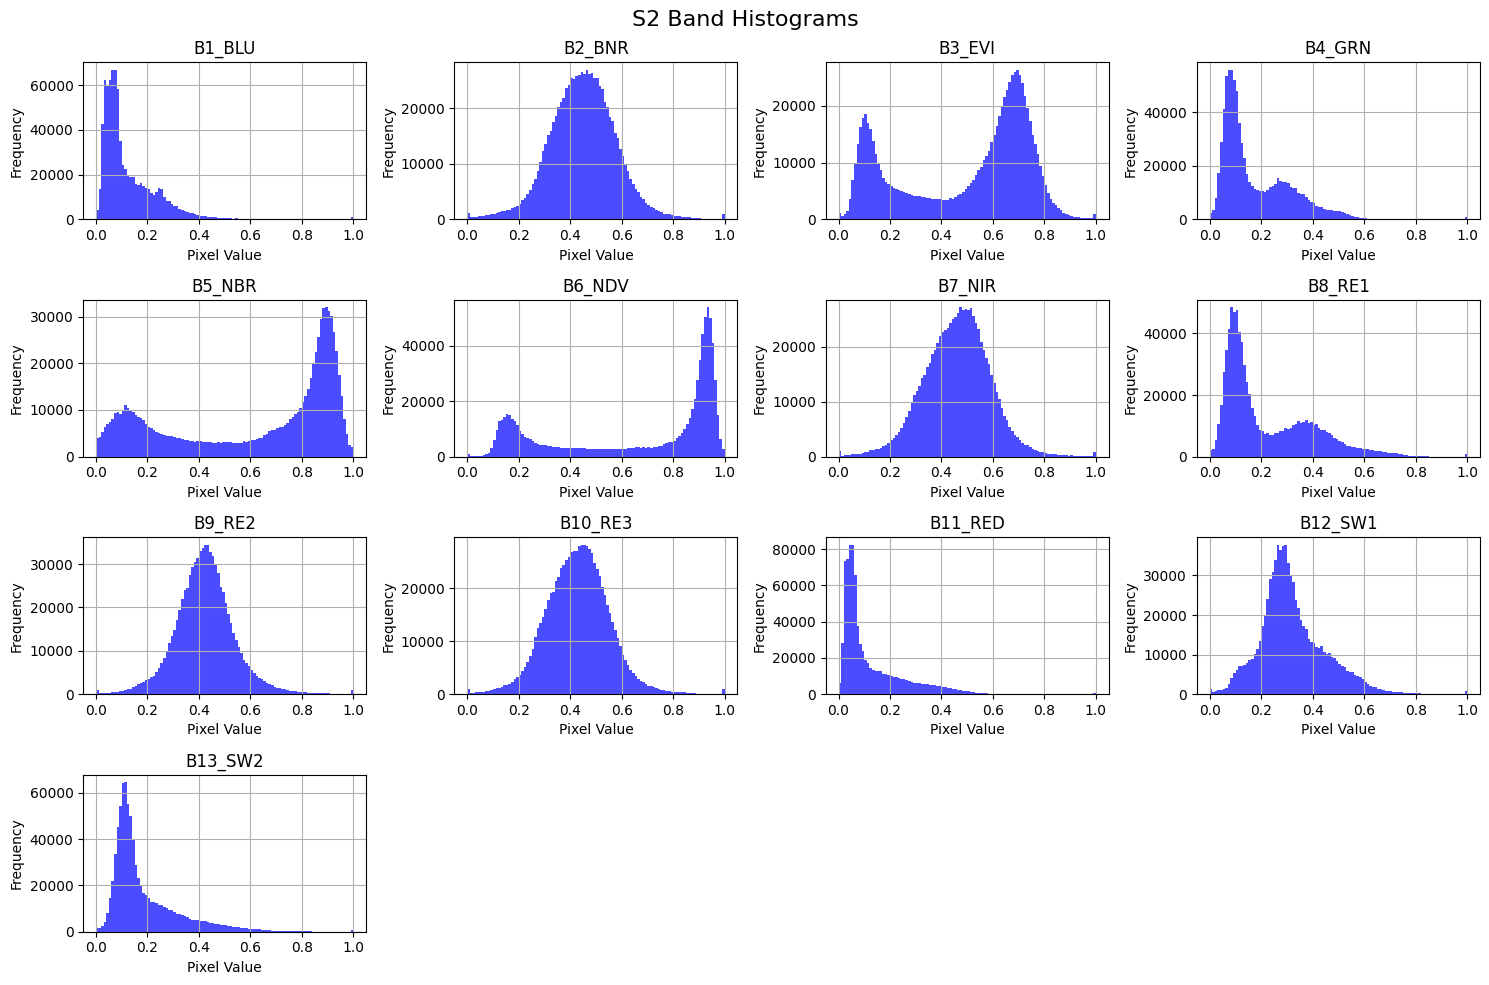

In [11]:
pt.plot_s2_histograms_and_percentiles(s2_np, num_bands=13,band_names=band_names)
pt.plot_s2_histograms_and_percentiles(s2_np2, num_bands=13,band_names=band_names)

## Stats ALS vs ForestMask

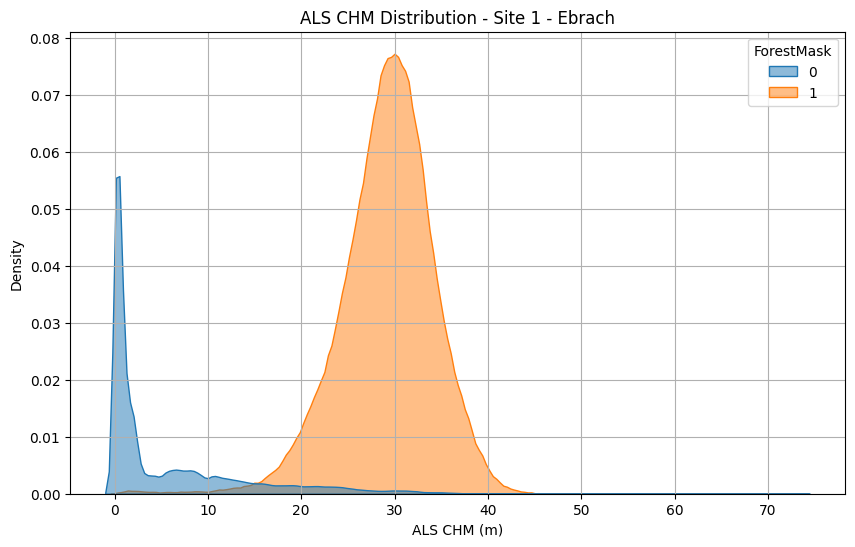

Some statistics for Site 1 - Ebrach:
Forest Mask: 			85.07% Forest
Share of ALS CHM > 2m: 		91.58%


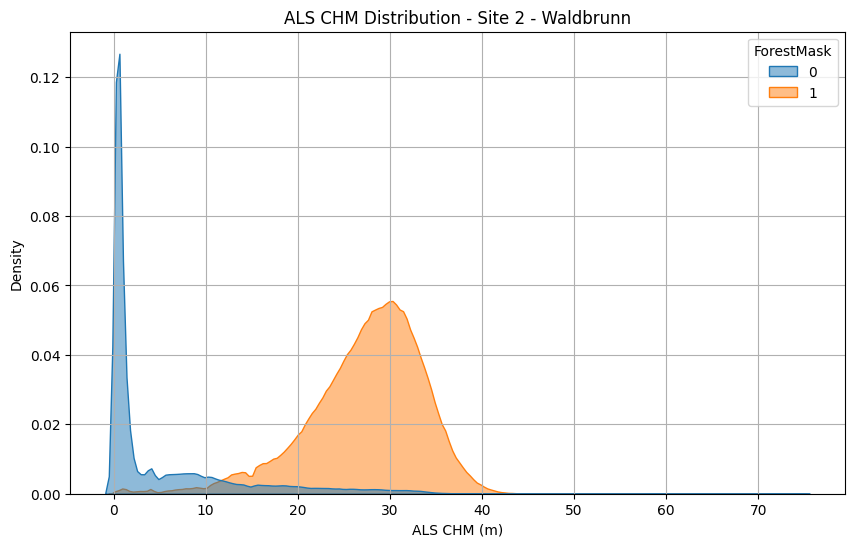

Some statistics for Site 2 - Waldbrunn:
Forest Mask: 			74.55% Forest
Share of ALS CHM > 2m: 		83.82%


In [5]:
import seaborn as sns

def plot_als_distribution(als_np, fmask, site_name):
    als_flat = als_np.flatten()
    fmask_flat = fmask.flatten()
    df = pd.DataFrame({'ALS': als_flat, 'ForestMask': fmask_flat})
    df = df.dropna()
    df['ForestMask'] = df['ForestMask'].astype(int).astype('category')

    plt.figure(figsize=(10, 6))
    ax = sns.kdeplot(data=df, x='ALS', hue='ForestMask', common_norm=True, fill=True, alpha=0.5, bw_adjust=0.4)
    plt.xlabel('ALS CHM (m)')
    plt.ylabel('Density')
    plt.title(f'ALS CHM Distribution - {site_name}')
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        plt.legend(title='Forest Mask', loc='upper right')
    plt.grid()
    plt.show()
    # also group by forest mask and print a descriptive statistics
    print(f"Some statistics for {site_name}:")

    print(f"Forest Mask: \t\t\t{df['ForestMask'].value_counts(normalize=True)[1] * 100:.2f}% Forest")
    # now print the share of area with ALS > 2m: df['ALS'] > 2 / df['ALS'].notna()
    print(f"Share of ALS CHM > 2m: \t\t{(df['ALS'] > 2).sum() / df['ALS'].notna().sum() * 100:.2f}%")


    #df.groupby('ForestMask')['ALS'].describe()

plot_als_distribution(als_np, fmask1, 'Site 1 - Ebrach')
plot_als_distribution(als_np2, fmask2, 'Site 2 - Waldbrunn')


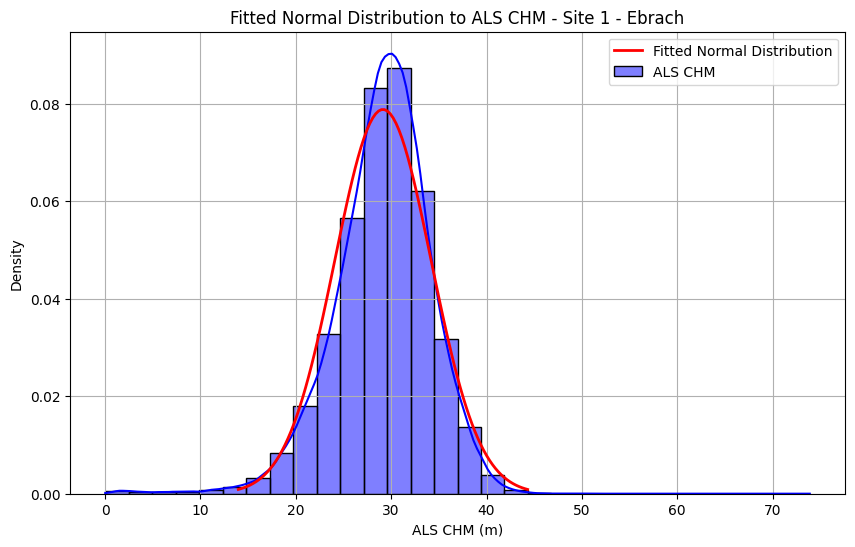

Fitted Normal Distribution Parameters for Site 1 - Ebrach:
Mean (mu): 29.14 m
Standard Deviation (std): 5.06 m


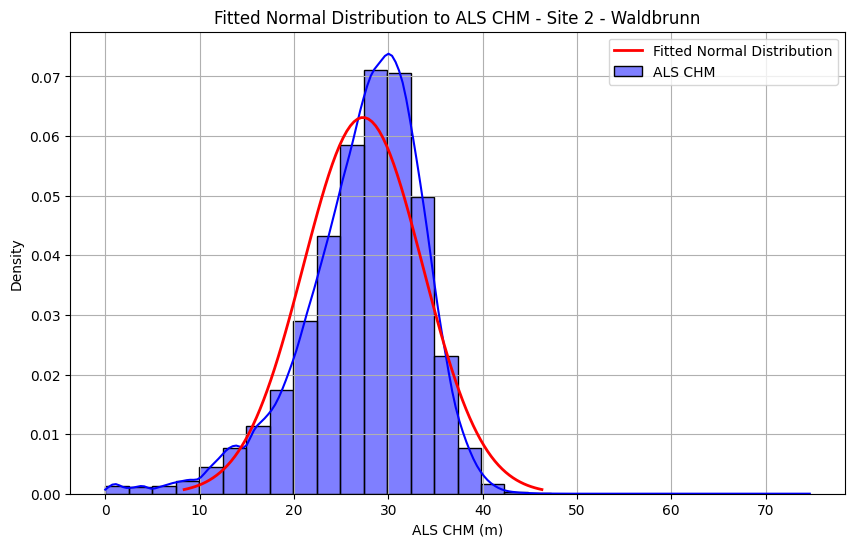

Fitted Normal Distribution Parameters for Site 2 - Waldbrunn:
Mean (mu): 27.33 m
Standard Deviation (std): 6.32 m


In [44]:
# now were only interested in the forest mask, so we can filter the ALS data. then we try to fit a statistical distribution to the data
def fit_distribution_to_als(als_np, fmask, site_name):
    als_flat = als_np.flatten()
    fmask_flat = fmask.flatten()
    df = pd.DataFrame({'ALS': als_flat, 'ForestMask': fmask_flat})
    df = df.dropna()
    df['ForestMask'] = df['ForestMask'].astype(int).astype('category')

    # Filter for forest mask
    df_forest = df[df['ForestMask'] == 1]

    # Fit a normal distribution to the ALS data
    mu, std = np.mean(df_forest['ALS']), np.std(df_forest['ALS'])
    
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df_forest['ALS'], kde=True, stat='density', bins=30, color='blue', label='ALS CHM')
    
    # Plot the fitted normal distribution
    x = np.linspace(mu - 3*std, mu + 3*std, 100)
    p = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / std) ** 2)
    plt.plot(x, p, 'r-', lw=2, label='Fitted Normal Distribution')
    
    plt.xlabel('ALS CHM (m)')
    plt.ylabel('Density')
    plt.title(f'Fitted Normal Distribution to ALS CHM - {site_name}')
    plt.legend()
    plt.grid()
    plt.show()
    # Print the parameters of the fitted distribution
    print(f"Fitted Normal Distribution Parameters for {site_name}:")
    print(f"Mean (mu): {mu:.2f} m")
    print(f"Standard Deviation (std): {std:.2f} m")

fit_distribution_to_als(als_np, fmask1, 'Site 1 - Ebrach')
fit_distribution_to_als(als_np2, fmask2, 'Site 2 - Waldbrunn')

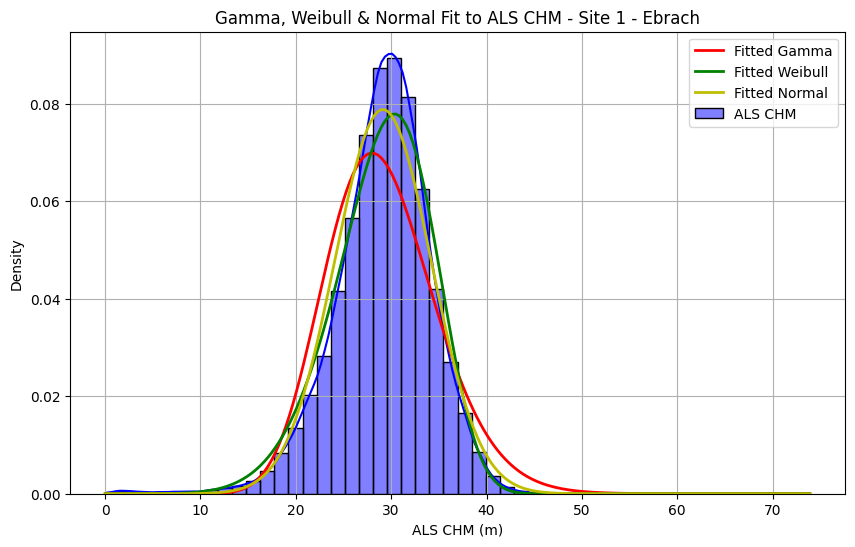

Gamma parameters for Site 1 - Ebrach: shape=25.23, loc=0.00, scale=1.16
Weibull parameters for Site 1 - Ebrach: shape=6.52, loc=0.00, scale=31.14
Normal parameters for Site 1 - Ebrach: mean=29.14, std=5.06

Log-likelihoods:
  Gamma:   -1341583.87
  Weibull: -1289231.08
  Normal:  -1289108.16

AIC (lower is better):
  Gamma:   2683171.75
  Weibull: 2578466.16
  Normal:  2578220.32


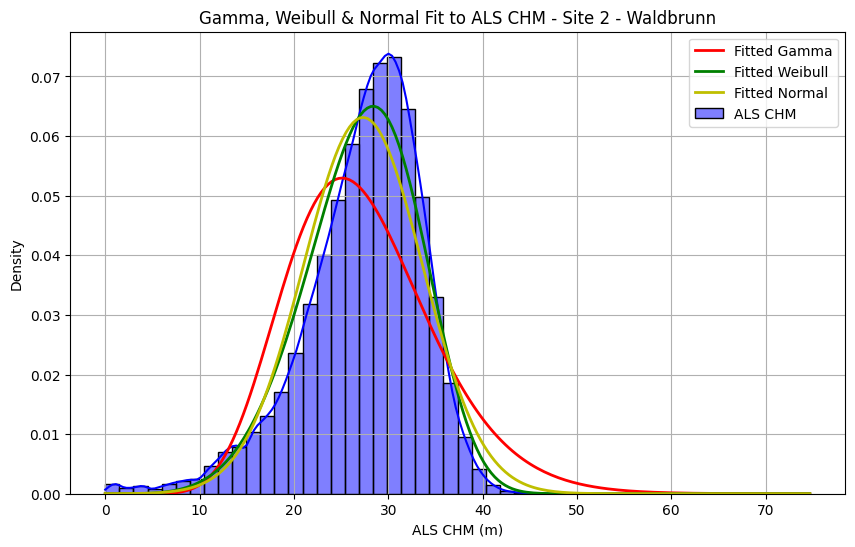

Gamma parameters for Site 2 - Waldbrunn: shape=12.27, loc=0.00, scale=2.23
Weibull parameters for Site 2 - Waldbrunn: shape=5.13, loc=0.00, scale=29.63
Normal parameters for Site 2 - Waldbrunn: mean=27.33, std=6.32

Log-likelihoods:
  Gamma:   -1140581.51
  Weibull: -1078157.40
  Normal:  -1079996.75

AIC (lower is better):
  Gamma:   2281167.03
  Weibull: 2156318.80
  Normal:  2159997.50


In [50]:
from scipy.stats import gamma, weibull_min, norm

def fit_gamma_weibull_normal_to_als(als_np, fmask, site_name):
    als_flat = als_np.flatten()
    fmask_flat = fmask.flatten()
    df = pd.DataFrame({'ALS': als_flat, 'ForestMask': fmask_flat})
    df = df.dropna()
    df['ForestMask'] = df['ForestMask'].astype(int).astype('category')

    # Filter for forest mask
    df_forest = df[df['ForestMask'] == 1]
    als_forest = df_forest['ALS'].values

    # Fit distributions
    gamma_params = gamma.fit(als_forest, floc=0)
    weibull_params = weibull_min.fit(als_forest, floc=0)
    norm_params = norm.fit(als_forest)

    # Plot histogram and fitted distributions
    plt.figure(figsize=(10, 6))
    sns.histplot(als_forest, kde=True, stat='density', bins=50, color='blue', label='ALS CHM')

    x = np.linspace(als_forest.min(), als_forest.max(), 200)
    plt.plot(x, gamma.pdf(x, *gamma_params), 'r-', lw=2, label='Fitted Gamma')
    plt.plot(x, weibull_min.pdf(x, *weibull_params), 'g-', lw=2, label='Fitted Weibull')
    plt.plot(x, norm.pdf(x, *norm_params), 'y-', lw=2, label='Fitted Normal')

    plt.xlabel('ALS CHM (m)')
    plt.ylabel('Density')
    plt.title(f'Gamma, Weibull & Normal Fit to ALS CHM - {site_name}')
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate log-likelihoods and AIC for each distribution
    loglik_gamma = np.sum(gamma.logpdf(als_forest, *gamma_params))
    loglik_weibull = np.sum(weibull_min.logpdf(als_forest, *weibull_params))
    loglik_norm = np.sum(norm.logpdf(als_forest, *norm_params))

    n = len(als_forest)
    k_gamma = 2  # shape, scale (loc fixed)
    k_weibull = 2  # shape, scale (loc fixed)
    k_norm = 2  # mean, std

    aic_gamma = 2 * k_gamma - 2 * loglik_gamma
    aic_weibull = 2 * k_weibull - 2 * loglik_weibull
    aic_norm = 2 * k_norm - 2 * loglik_norm

    print(f"Gamma parameters for {site_name}: shape={gamma_params[0]:.2f}, loc={gamma_params[1]:.2f}, scale={gamma_params[2]:.2f}")
    print(f"Weibull parameters for {site_name}: shape={weibull_params[0]:.2f}, loc={weibull_params[1]:.2f}, scale={weibull_params[2]:.2f}")
    print(f"Normal parameters for {site_name}: mean={norm_params[0]:.2f}, std={norm_params[1]:.2f}")
    print()
    print(f"Log-likelihoods:")
    print(f"  Gamma:   {loglik_gamma:.2f}")
    print(f"  Weibull: {loglik_weibull:.2f}")
    print(f"  Normal:  {loglik_norm:.2f}")
    print()
    print(f"AIC (lower is better):")
    print(f"  Gamma:   {aic_gamma:.2f}")
    print(f"  Weibull: {aic_weibull:.2f}")
    print(f"  Normal:  {aic_norm:.2f}")

fit_gamma_weibull_normal_to_als(als_np, fmask1, 'Site 1 - Ebrach')
fit_gamma_weibull_normal_to_als(als_np2, fmask2, 'Site 2 - Waldbrunn')

# ALS Normalization

## ... each site individually

In [13]:
import json

# now i want a way to normalize the als data, and store their parameters for later use
def normalize_als(als_np, fmask, site_name, als_path=ALS_PATH1_RES):
    als_flat = als_np.flatten()
    fmask_flat = fmask.flatten()
    df = pd.DataFrame({'ALS': als_flat, 'ForestMask': fmask_flat})
    df = df.dropna()
    df['ForestMask'] = df['ForestMask'].astype(int).astype('category')

    # Filter for forest mask
    df_forest = df[df['ForestMask'] == 1]
    als_forest = df_forest['ALS'].values

    # Fit a normal distribution to the ALS data
    mu, std = np.mean(als_forest), np.std(als_forest)

    # Normalize the ALS data
    als_normalized = (als_np - mu) / std

    # Save the normalization parameters
    normalization_params = {
        'site_name': site_name,
        'mu': mu,
        'std': std
    }
    normalization_file = f'../data/02_processed/ALS_norm_params_{site_name}.json'
    # Save the normalization parameters as a JSON file (do it here, not in bsc)
    # Convert float32 to float for JSON serialization
    normalization_params = {k: float(v) if isinstance(v, np.floating) else v for k, v in normalization_params.items()}
    with open(normalization_file, 'w') as f:
        json.dump(normalization_params, f, indent=4)

    print(f"Normalization parameters saved to {normalization_file}")

    # also save the normalized ALS data
    normalized_als_file = f'../data/02_processed/ALS_norm_{site_name}.tif'
    # save the normalized ALS data as a GeoTIFF
    # Use the transform and crs from the reference ALS file
    ref_path = als_path if 'als_path' in locals() else ALS_PATH1_RES
    with rasterio.open(ref_path) as ref:
        transform = ref.transform
        crs = ref.crs

    with rasterio.open(normalized_als_file, 'w', driver='GTiff',
                       height=als_normalized.shape[0],
                       width=als_normalized.shape[1],
                       count=1,
                       dtype=als_normalized.dtype,
                       crs=crs,
                       transform=transform) as dst:
        dst.write(als_normalized, 1)
        dst.write(als_normalized, 1)

    return als_normalized, normalization_params

In [14]:
als_normalized1,_ = normalize_als(als_np, fmask1, 'Site1_Ebrach',ALS_PATH1_RES)
als_normalized2,_ = normalize_als(als_np2, fmask2, 'Site2_Waldbrunn',ALS_PATH2_RES)

Normalization parameters saved to ../data/02_processed/ALS_norm_params_Site1_Ebrach.json
Normalization parameters saved to ../data/02_processed/ALS_norm_params_Site2_Waldbrunn.json


## ... for the union of both ALS Sites

In [10]:
# Variant 2: Calculate normalization parameters over the union of both sites (forest areas only),
# then normalize each ALS file using these joint parameters and store them.
import json

def compute_joint_als_norm_params(als1, fmask1, als2, fmask2):
    # Ensure fmasks are integer type for comparison
    fmask1_bin = (fmask1.astype(int) == 1)
    fmask2_bin = (fmask2.astype(int) == 1)

    # Mask out NaNs in ALS arrays and select only forest pixels
    als1_valid = als1[~np.isnan(als1) & fmask1_bin]
    als2_valid = als2[~np.isnan(als2) & fmask2_bin]

    # Concatenate valid forest ALS values from both sites
    als_union = np.concatenate([als1_valid, als2_valid])

    # Remove any remaining NaNs (shouldn't be any, but for safety)
    als_union = als_union[~np.isnan(als_union)]

    mu = np.mean(als_union)
    std = np.std(als_union)
    print(f"Joint normalization parameters:\n \tµ: \t{mu:.2f}m\n \tstd: \t{std:.2f}m")
    return mu, std

def normalize_als_with_params(als_np, mu, std, als_path, out_name):
    als_normalized = (als_np - mu) / std
    # Save normalized ALS as GeoTIFF
    with rasterio.open(als_path) as ref:
        transform = ref.transform
        crs = ref.crs
    out_path = f'../data/02_processed/ALS_norm_{out_name}_joint.tif'
    with rasterio.open(out_path, 'w', driver='GTiff',
                       height=als_normalized.shape[0],
                       width=als_normalized.shape[1],
                       count=1,
                       dtype=als_normalized.dtype,
                       crs=crs,
                       transform=transform) as dst:
        dst.write(als_normalized, 1)
    return als_normalized

# Compute joint normalization parameters
mu_joint, std_joint = compute_joint_als_norm_params(als_np, fmask1, als_np2, fmask2)

# Save joint parameters
joint_params = {'mu': float(mu_joint), 'std': float(std_joint)}
with open('../data/02_processed/ALS_norm_params_joint.json', 'w') as f:
    json.dump(joint_params, f, indent=4)
print("Joint normalization parameters saved to ../data/02_processed/ALS_norm_params_joint.json")

# Normalize both ALS datasets using joint parameters
als_normalized1_joint = normalize_als_with_params(als_np, mu_joint, std_joint, ALS_PATH1_RES, 'Site1_Ebrach')
als_normalized2_joint = normalize_als_with_params(als_np2, mu_joint, std_joint, ALS_PATH2_RES, 'Site2_Waldbrunn')


Joint normalization parameters:
 	µ: 	28.35m
 	std: 	5.72m
Joint normalization parameters saved to ../data/02_processed/ALS_norm_params_joint.json


little sanity check

In [15]:
nan_count = np.sum(np.isnan(als_normalized1))
print(f"Number of NaN values in normalized ALS Site 1: {nan_count}")

Number of NaN values in normalized ALS Site 1: 551421


In [17]:
nan_count = np.sum(np.isnan(als_normalized1_joint))
print(f"Number of NaN values in normalized ALS Site 1 joint: {nan_count}")

Number of NaN values in normalized ALS Site 1 joint: 551421
